In [2]:
#### Mapping the hiit peptides to the protein

## This code needs the protein sequence file for 3D7 or IT in the 'Input_protein_sequences'folder in Dryad

from collections import defaultdict
import pandas as pd 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 
import numpy as np
z_hit_8 = pd.read_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv',header=0,index_col = 'peptide')
df_meta = pd.read_excel('Ugandan_samples_metadata.xlsx',header=0,index_col = 'Barcode',engine = 'openpyxl')
z_hit_8_withmeta = pd.merge(z_hit_8.T, df_meta, left_index=True, right_index=True).T
z_hit_8_withmeta_Tororo = z_hit_8_withmeta.filter(regex = 'CT3',axis=1)
z_hit_8_withmeta_Kanungu = z_hit_8_withmeta.filter(regex = 'CK3',axis=1)

####get the fasta protein files and collect protein names and amino acid length 

proteome = open("....fasta","r") ## Protein sequence file for 3D7 or IT in the 'Input_protein_sequences'folder in Dryad
prot_seq = {}
prot_len = {}

for line in proteome:
    gene = line.strip("\n")[1:] ###taking the content after '>' in the fasta file 
    if '|' in gene:
        gene_new = gene.split('.')[0].strip(' ') #print gene_full
        gene = gene_new
        
    line2 = next(proteome)
    seq = line2.strip("\n")
    length=len(seq)
    prot_len[gene] = length
    prot_seq[gene] = seq
proteome.close()

### converting peptide position to protein reesidue position
peptide_position = defaultdict(tuple) ## collecting list of proteins and corresponding residue positions and aligning peptides as a set for each residue 

for i in range(1,10000): ## going through each peptide in the dictionary

    
    protein_start_pos = (i-1)*25   + 1 ## peptide positions go from 1 to 62; 1 in peptide position equals residue start (so we subtract by 1)
    protein_end_pos = protein_start_pos + 61
    peptide_position[i] = (protein_start_pos,protein_end_pos)

temp = z_hit_8_withmeta_Kanungu.T
z_hit_8_withmeta_Kanungu_child = temp[temp['age']<18].T
print (z_hit_8_withmeta_Kanungu_child.shape)

temp = z_hit_8_withmeta_Tororo.T
z_hit_8_withmeta_Tororo_child = temp[temp['age']<18].T
print (z_hit_8_withmeta_Tororo_child.shape)

temp = z_hit_8_withmeta_Kanungu.T
z_hit_8_withmeta_Kanungu_adult = temp[temp['age']>18].T
print (z_hit_8_withmeta_Kanungu_adult.shape)

temp = z_hit_8_withmeta_Tororo.T
z_hit_8_withmeta_Tororo_adult = temp[temp['age']>18].T
print (z_hit_8_withmeta_Tororo_adult.shape)

(9946, 70)
(9946, 69)
(9946, 30)
(9946, 29)


PF3D7_0304600 397


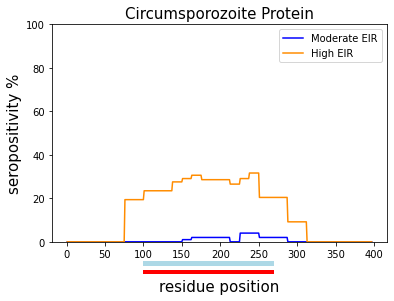

In [3]:
import re
gene = 'PF3D7_0304600'
hit_peptides = z_hit_8.filter(regex = re.compile('{}'.format(gene)), axis=0).index

protein_length = prot_len[gene]
print (gene, str(protein_length))
df_signal = pd.DataFrame(columns=['Moderate EIR','High EIR'],index=[i for i in range(1,protein_length+1)])  ### creates a new dataframe for each protein and add residues corresponding to length as index

dict_kanungu = defaultdict(list)
dict_tororo = defaultdict(list)

for i in range(1,protein_length+1):
    ### setting the default value to zero at all residues
    dict_kanungu[i] = [0]
    dict_tororo[i] = [0]

for pep in hit_peptides:
    number = int(pep.split("_seq")[-1])
    start,end = peptide_position[number][0],peptide_position[number][1]

    kanungu_seropositivity = z_hit_8_withmeta_Kanungu.loc[pep].sum()
    tororo_seropositivity = z_hit_8_withmeta_Tororo.loc[pep].sum()
    
    for i in range(start,end+1): ### append the immunogenicity for the positions covered by the peptide
        if dict_kanungu[i] == [0]:
            dict_kanungu[i]= [kanungu_seropositivity] ## Replace 0 if this is the first immunogenicty value being added
        else:
            dict_kanungu[i].append(kanungu_seropositivity)
        
        if dict_tororo[i] == [0]:    
            dict_tororo[i] = [tororo_seropositivity]
        else:
            dict_tororo[i].append(tororo_seropositivity)
def Average(lst):
    return sum(lst) / len(lst)
       
        
for i in range(1,protein_length+1): ### change the dataframe for locations which have non-zero immunogeniciity
    
    df_signal.loc[i, 'High EIR'] = (Average(dict_tororo[i])*100/98)
    df_signal.loc[i, 'Moderate EIR'] = (Average(dict_kanungu[i])*100/100)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
# df_signal.plot( y=['Kanungu_min'],kind='line',legend = True,color = 'lightgreen' , ax=ax)
# df_signal.plot( y=['Kanungu_max'],kind='line',legend = True,color = 'green', ax=ax)

# df_signal.plot( y=['Tororo_min'],kind='line',legend = True,color = 'lightyellow' , ax=ax)
# df_signal.plot( y=['Tororo_max'],kind='line',legend = True,color = 'yellow', ax=ax)

df_signal.plot( y=['Moderate EIR'],kind='line',legend = True,color = 'blue' , ax=ax)
df_signal.plot( y=['High EIR'],kind='line',legend = True,color = 'darkorange' , ax=ax)


ax.set_xlabel('residue position',size = 15,labelpad = 20)
ax.set_ylabel('seropositivity %', size = 15)
ax.set_ylim(0,100)
ax.set_title(gene,size=15)


'''CHANGE HERE'''

ax.set_title('Circumsporozoite Protein',size=15)   
ax.add_patch(plt.Rectangle((100,-11),170, 2,facecolor='lightblue',clip_on=False,linewidth = 0))


### Adding tracks of repeat regions 

'''CHANGE HERE'''
low_complexity = [(100,270)]
        
for region in low_complexity:
    x = int(region[0])
    width = int(region[1])-int(region[0])
    
    ax.add_patch(plt.Rectangle((x,-15),width, 2,facecolor='red',clip_on=False,linewidth = 0))
    
#plt.savefig('Fig2c_CSP.pdf', dpi=800,bbox_inches='tight')


plt.show()




PF3D7_0501400 1720


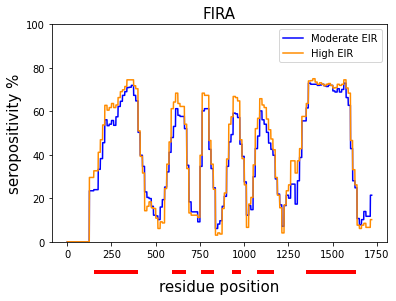

In [4]:
import re
gene = 'PF3D7_0501400'
hit_peptides = z_hit_8.filter(regex = re.compile('{}'.format(gene)), axis=0).index

protein_length = prot_len[gene]
print (gene, str(protein_length))
df_signal = pd.DataFrame(columns=['Moderate EIR','High EIR'],index=[i for i in range(1,protein_length+1)])  ### creates a new dataframe for each protein and add residues corresponding to length as index

dict_kanungu = defaultdict(list)
dict_tororo = defaultdict(list)

for i in range(1,protein_length+1):
    ### setting the default value to zero at all residues
    dict_kanungu[i] = [0]
    dict_tororo[i] = [0]

for pep in hit_peptides:
    number = int(pep.split("_seq")[-1])
    start,end = peptide_position[number][0],peptide_position[number][1]

    kanungu_seropositivity = z_hit_8_withmeta_Kanungu.loc[pep].sum()
    tororo_seropositivity = z_hit_8_withmeta_Tororo.loc[pep].sum()
    
    for i in range(start,end+1): ### append the immunogenicity for the positions covered by the peptide
        if dict_kanungu[i] == [0]:
            dict_kanungu[i]= [kanungu_seropositivity] ## Replace 0 if this is the first immunogenicty value being added
        else:
            dict_kanungu[i].append(kanungu_seropositivity)
        
        if dict_tororo[i] == [0]:    
            dict_tororo[i] = [tororo_seropositivity]
        else:
            dict_tororo[i].append(tororo_seropositivity)
def Average(lst):
    return sum(lst) / len(lst)
       
        
for i in range(1,protein_length+1): ### change the dataframe for locations which have non-zero immunogeniciity
    
    df_signal.loc[i, 'High EIR'] = (Average(dict_tororo[i])*100/98)
    df_signal.loc[i, 'Moderate EIR'] = (Average(dict_kanungu[i])*100/98)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
# df_signal.plot( y=['Kanungu_min'],kind='line',legend = True,color = 'lightgreen' , ax=ax)
# df_signal.plot( y=['Kanungu_max'],kind='line',legend = True,color = 'green', ax=ax)

# df_signal.plot( y=['Tororo_min'],kind='line',legend = True,color = 'lightyellow' , ax=ax)
# df_signal.plot( y=['Tororo_max'],kind='line',legend = True,color = 'yellow', ax=ax)

df_signal.plot( y=['Moderate EIR'],kind='line',legend = True,color = 'blue' , ax=ax)
df_signal.plot( y=['High EIR'],kind='line',legend = True,color = 'darkorange' , ax=ax)


ax.set_xlabel('residue position',size = 15,labelpad = 20)
ax.set_ylabel('seropositivity %', size = 15)
ax.set_ylim(0,100)
ax.set_title('FIRA',size=15)


### Adding tracks of repeat regions 

'''CHANGE HERE'''
low_complexity_1 = [(150,400),(590,670),(755,830),(930,980),(1070,1170),(1350,1630)]


for region in low_complexity_1:
    x = int(region[0])
    width = int(region[1])-int(region[0])
    
    ax.add_patch(plt.Rectangle((x,-15),width, 2,facecolor='red',clip_on=False,linewidth = 0))



#plt.savefig('Fig2c_FIRA.pdf', dpi=800,bbox_inches='tight')

plt.show()





PF3D7_0220000 1558


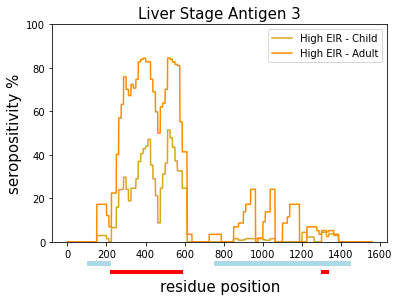

In [21]:

'''CHANGE HERE'''
gene = 'PF3D7_0220000' 
hit_peptides = z_hit_8.filter(regex = re.compile('{}'.format(gene)), axis=0).index


protein_length = prot_len[gene]
print (gene, protein_length)
df_signal = pd.DataFrame(columns=['High EIR - Child', 'High EIR - Adult'],index=[i for i in range(1,protein_length+1)])  ### creates a new dataframe for each protein and add residues corresponding to length as index

dict_child = defaultdict(list)
dict_adult = defaultdict(list)

for i in range(1,protein_length+1):
    ### setting the default value to zero at all residues
    dict_child[i] = [0]
    dict_adult[i] = [0]

for pep in hit_peptides:
    number = int(pep.split("_seq")[-1])
    start,end = peptide_position[number][0],peptide_position[number][1]

    child_seropositivity = (z_hit_8_withmeta_Tororo_child.loc[pep].sum())/0.69
    adult_seropositivity = (z_hit_8_withmeta_Tororo_adult.loc[pep].sum())/0.29
    
    for i in range(start,end+1): ### append the immunogenicity for the positions covered by the peptide
        if dict_child[i] == [0]:
            dict_child[i]= [child_seropositivity] ## Replace 0 if this is the first immunogenicty value being added
        else:
            dict_child[i].append(child_seropositivity)
        
        if dict_adult[i] == [0]:    
            dict_adult[i] = [adult_seropositivity]
        else:
            dict_adult[i].append(adult_seropositivity)
        
def Average(lst):
    return sum(lst) / len(lst)
    
for i in range(1,protein_length+1): ### change the dataframe for locations which have non-zero immunogeniciity
    
    df_signal.loc[i, 'High EIR - Adult'] = Average(dict_adult[i])
    df_signal.loc[i, 'High EIR - Child'] = Average(dict_child[i])


import matplotlib.pyplot as plt
fig,ax = plt.subplots()
df_signal.plot( y=['High EIR - Child'],kind='line',legend = True,color = 'goldenrod' , ax=ax)
df_signal.plot( y=['High EIR - Adult'],kind='line',legend = True,color = 'darkorange', ax=ax)


ax.set_xlabel('residue position',size = 15,labelpad = 20)
ax.set_ylabel('seropositivity %', size = 15)
ax.set_ylim(0,100)
ax.set_title(gene,size=15)


'''CHANGE HERE'''

ax.set_title('Liver Stage Antigen 3',size=15)   
ax.add_patch(plt.Rectangle((750,-11),700, 2,facecolor='lightblue',clip_on=False,linewidth = 0))## Morita 2017
ax.add_patch(plt.Rectangle((100,-11),122, 2,facecolor='lightblue',clip_on=False,linewidth = 0)) ## Perlaza et. al 2008

### Adding tracks of repeat regions based on observing the sequence 

low_complexity = [(220,278),(280,590),(1300,1340)]
        
for region in low_complexity:
    x = int(region[0])
    width = int(region[1])-int(region[0])
    
    ax.add_patch(plt.Rectangle((x,-15),width, 2,facecolor='red',clip_on=False,linewidth = 0))
    
#plt.savefig('Fig2c_LSA3.pdf', dpi=800,bbox_inches='tight')

plt.show()

PF3D7_0935900 713


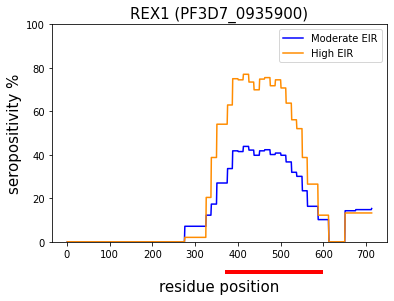

In [5]:
'REX1'
import re
gene = 'PF3D7_0935900'
hit_peptides = z_hit_8.filter(regex = re.compile('{}'.format(gene)), axis=0).index

protein_length = prot_len[gene]
print (gene, str(protein_length))
df_signal = pd.DataFrame(columns=['Moderate EIR','High EIR'],index=[i for i in range(1,protein_length+1)])  ### creates a new dataframe for each protein and add residues corresponding to length as index

dict_kanungu = defaultdict(list)
dict_tororo = defaultdict(list)

for i in range(1,protein_length+1):
    ### setting the default value to zero at all residues
    dict_kanungu[i] = [0]
    dict_tororo[i] = [0]

for pep in hit_peptides:
    number = int(pep.split("_seq")[-1])
    start,end = peptide_position[number][0],peptide_position[number][1]

    kanungu_seropositivity = z_hit_8_withmeta_Kanungu.loc[pep].sum()
    tororo_seropositivity = z_hit_8_withmeta_Tororo.loc[pep].sum()
    
    for i in range(start,end+1): ### append the immunogenicity for the positions covered by the peptide
        if dict_kanungu[i] == [0]:
            dict_kanungu[i]= [kanungu_seropositivity] ## Replace 0 if this is the first immunogenicty value being added
        else:
            dict_kanungu[i].append(kanungu_seropositivity)
        
        if dict_tororo[i] == [0]:    
            dict_tororo[i] = [tororo_seropositivity]
        else:
            dict_tororo[i].append(tororo_seropositivity)
def Average(lst):
    return sum(lst) / len(lst)
       
        
for i in range(1,protein_length+1): ### change the dataframe for locations which have non-zero immunogeniciity
    
    df_signal.loc[i, 'High EIR'] = (Average(dict_tororo[i])*100/98)
    df_signal.loc[i, 'Moderate EIR'] = (Average(dict_kanungu[i])*100/98)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
# df_signal.plot( y=['Kanungu_min'],kind='line',legend = True,color = 'lightgreen' , ax=ax)
# df_signal.plot( y=['Kanungu_max'],kind='line',legend = True,color = 'green', ax=ax)

# df_signal.plot( y=['Tororo_min'],kind='line',legend = True,color = 'lightyellow' , ax=ax)
# df_signal.plot( y=['Tororo_max'],kind='line',legend = True,color = 'yellow', ax=ax)

df_signal.plot( y=['Moderate EIR'],kind='line',legend = True,color = 'blue' , ax=ax)
df_signal.plot( y=['High EIR'],kind='line',legend = True,color = 'darkorange' , ax=ax)


ax.set_xlabel('residue position',size = 15,labelpad = 20)
ax.set_ylabel('seropositivity %', size = 15)
ax.set_ylim(0,100)
ax.set_title('REX1 (' + gene + ')' ,size=15)


### Adding tracks of repeat regions based on looking at the sequence


'''CHANGE HERE'''
low_complexity = [(370,600)]
       
for region in low_complexity:
    x = int(region[0])
    width = int(region[1])-int(region[0])    
    ax.add_patch(plt.Rectangle((x,-15),width, 2,facecolor='red',clip_on=False,linewidth = 0))

#plt.savefig('Fig2d_REX1.pdf', dpi=800,bbox_inches='tight')

plt.show()



PF3D7_0801000 1219


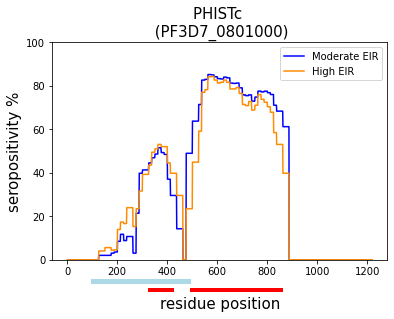

In [23]:

import re
gene = 'PF3D7_0801000'
hit_peptides = z_hit_8.filter(regex = re.compile('{}'.format(gene)), axis=0).index


protein_length = prot_len[gene]
print (gene, str(protein_length))
df_signal = pd.DataFrame(columns=['Moderate EIR','High EIR'],index=[i for i in range(1,protein_length+1)])  ### creates a new dataframe for each protein and add residues corresponding to length as index

dict_kanungu = defaultdict(list)
dict_tororo = defaultdict(list)

for i in range(1,protein_length+1):
    ### setting the default value to zero at all residues
    dict_kanungu[i] = [0]
    dict_tororo[i] = [0]

for pep in hit_peptides:
    number = int(pep.split("_seq")[-1])
    start,end = peptide_position[number][0],peptide_position[number][1]

    kanungu_seropositivity = z_hit_8_withmeta_Kanungu.loc[pep].sum()
    tororo_seropositivity = z_hit_8_withmeta_Tororo.loc[pep].sum()
    
    for i in range(start,end+1): ### append the immunogenicity for the positions covered by the peptide
        if dict_kanungu[i] == [0]:
            dict_kanungu[i]= [kanungu_seropositivity] ## Replace 0 if this is the first immunogenicty value being added
        else:
            dict_kanungu[i].append(kanungu_seropositivity)
        
        if dict_tororo[i] == [0]:    
            dict_tororo[i] = [tororo_seropositivity]
        else:
            dict_tororo[i].append(tororo_seropositivity)
def Average(lst):
    return sum(lst) / len(lst)
       
        
for i in range(1,protein_length+1): ### change the dataframe for locations which have non-zero immunogeniciity
    
    df_signal.loc[i, 'High EIR'] = (Average(dict_tororo[i])*100/98)
    df_signal.loc[i, 'Moderate EIR'] = (Average(dict_kanungu[i])*100/98)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
# df_signal.plot( y=['Kanungu_min'],kind='line',legend = True,color = 'lightgreen' , ax=ax)
# df_signal.plot( y=['Kanungu_max'],kind='line',legend = True,color = 'green', ax=ax)

# df_signal.plot( y=['Tororo_min'],kind='line',legend = True,color = 'lightyellow' , ax=ax)
# df_signal.plot( y=['Tororo_max'],kind='line',legend = True,color = 'yellow', ax=ax)

df_signal.plot( y=['Moderate EIR'],kind='line',legend = True,color = 'blue' , ax=ax)
df_signal.plot( y=['High EIR'],kind='line',legend = True,color = 'darkorange' , ax=ax)


ax.set_xlabel('residue position',size = 15,labelpad = 20)
ax.set_ylabel('seropositivity %', size = 15)
ax.set_ylim(0,100)
ax.set_title('PHISTc \n (' + gene + ')' ,size=15)


### Adding tracks of repeat regions based on looking at the sequence


'''CHANGE HERE'''
low_complexity = [(324,426),(490,865)]
       
for region in low_complexity:
    x = int(region[0])
    width = int(region[1])-int(region[0])    
    ax.add_patch(plt.Rectangle((x,-15),width, 2,facecolor='red',clip_on=False,linewidth = 0))
ax.add_patch(plt.Rectangle((93,-11),401, 2,facecolor='lightblue',clip_on=False,linewidth = 0)) # Nagaoka, 2021


#plt.savefig('Fig3_PHISTc.pdf', dpi=800,bbox_inches='tight')

plt.show()







PF3D7_1116000 1201


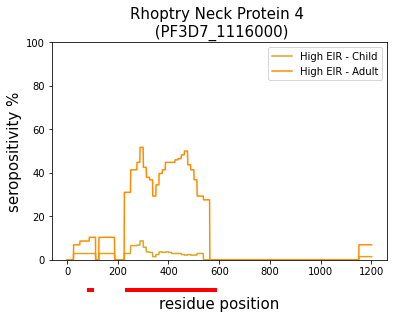

In [6]:

'''CHANGE HERE'''
gene = 'PF3D7_1116000' 
hit_peptides = z_hit_8.filter(regex = re.compile('{}'.format(gene)), axis=0).index


protein_length = prot_len[gene]
print (gene, protein_length)
df_signal = pd.DataFrame(columns=['High EIR - Child', 'High EIR - Adult'],index=[i for i in range(1,protein_length+1)])  ### creates a new dataframe for each protein and add residues corresponding to length as index

dict_child = defaultdict(list)
dict_adult = defaultdict(list)

for i in range(1,protein_length+1):
    ### setting the default value to zero at all residues
    dict_child[i] = [0]
    dict_adult[i] = [0]

for pep in hit_peptides:
    number = int(pep.split("_seq")[-1])
    start,end = peptide_position[number][0],peptide_position[number][1]

    child_seropositivity = (z_hit_8_withmeta_Tororo_child.loc[pep].sum())/0.69
    adult_seropositivity = (z_hit_8_withmeta_Tororo_adult.loc[pep].sum())/0.29
    
    for i in range(start,end+1): ### append the immunogenicity for the positions covered by the peptide
        if dict_child[i] == [0]:
            dict_child[i]= [child_seropositivity] ## Replace 0 if this is the first immunogenicty value being added
        else:
            dict_child[i].append(child_seropositivity)
        
        if dict_adult[i] == [0]:    
            dict_adult[i] = [adult_seropositivity]
        else:
            dict_adult[i].append(adult_seropositivity)
        
def Average(lst):
    return sum(lst) / len(lst)
    
for i in range(1,protein_length+1): ### change the dataframe for locations which have non-zero immunogeniciity
    
    df_signal.loc[i, 'High EIR - Adult'] = Average(dict_adult[i])
    df_signal.loc[i, 'High EIR - Child'] = Average(dict_child[i])


import matplotlib.pyplot as plt
fig,ax = plt.subplots()
df_signal.plot( y=['High EIR - Child'],kind='line',legend = True,color = 'goldenrod' , ax=ax)
df_signal.plot( y=['High EIR - Adult'],kind='line',legend = True,color = 'darkorange', ax=ax)


ax.set_xlabel('residue position',size = 15,labelpad = 20)
ax.set_ylabel('seropositivity %', size = 15)
ax.set_ylim(0,100)
ax.set_title(gene,size=15)


'''CHANGE HERE'''

ax.set_title('Rhoptry Neck Protein 4 \n (' + gene + ')',size=15)   

## Adding tracks of repeat regions based on observing the sequence 

low_complexity = [(80,105),(230,590)]
        
for region in low_complexity:
    x = int(region[0])
    width = int(region[1])-int(region[0])
    
    ax.add_patch(plt.Rectangle((x,-15),width, 2,facecolor='red',clip_on=False,linewidth = 0))
    
#plt.savefig('Fig2c_RON4.pdf', dpi=800,bbox_inches='tight')

plt.show()